# 0.0 Imports

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
import fitter

from pprint import pprint
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Auxiliary functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv( './data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( './data/store.csv', low_memory=False )

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
""" variables Promo2SinceWeek, Promo2SinceYear, PromoInterval were not considered in the first anlaysis
- Promo2Since[Year/Week]: the year and calendar week when the store started participating in Promo2
- romoInterval: describes the consecutive intervals Promo2 is started (months)
"""
df_raw = df_raw.drop(columns=['Promo2SinceWeek','Promo2SinceYear','PromoInterval'])

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
# rename columns from CamelCase to snake_case

cols_new = []
for cols in df1.columns:
    col_aux = inflection.underscore(cols)
    cols_new.append(col_aux)
    
# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 15


## 1.3 Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
dtype: object

In [9]:
# correct date type (from object to datetime)
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'] = df1['competition_distance'].fillna(200000)

df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
dtype: int64

###### 1.6 Descriptive Statistics

In [13]:
# separating numerical and categorical atributes

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1 Numerical Atributes

In [14]:
# Central Tendency - mean, meadina 
cen_tend1 = pd.DataFrame(num_attributes.mean()).T
cen_tend2 = pd.DataFrame(num_attributes.median()).T

# Dispersion - std, min, max, range, skew, kurtosis
stand_dev = pd.DataFrame(num_attributes.std()).T
minimum = pd.DataFrame(num_attributes.min()).T
maximum = pd.DataFrame(num_attributes.max()).T
variation = pd.DataFrame(num_attributes.max()-num_attributes.min()).T
skew1 = pd.DataFrame(num_attributes.skew()).T
kurtos1 = pd.DataFrame(num_attributes.kurtosis()).T

# saving all metrics into a dataframe
stat_metrics = pd.concat([cen_tend1,cen_tend2, stand_dev, 
                          minimum, maximum, variation, skew1, kurtos1])

stat_metrics.set_axis(['mean','median','std','min','max','range','skew','kurtosis'], axis=0).T

,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304


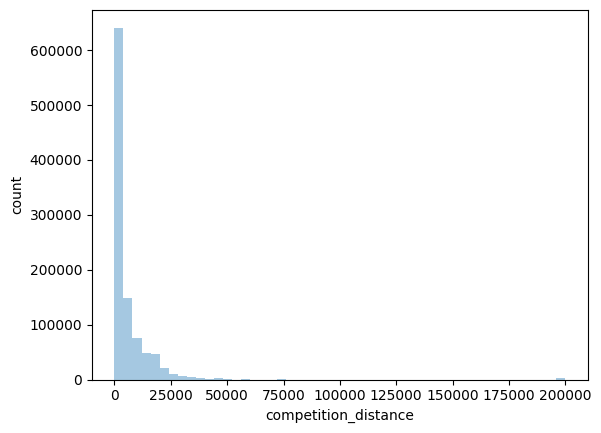

In [15]:
# high skew and kurtosis: competition_distance and competition_open_since_year 
fig = sns.distplot( df1['competition_distance'], kde=False )
# add label to the axis and label to the plot
fig.set(xlabel ="competition_distance", ylabel = "count");

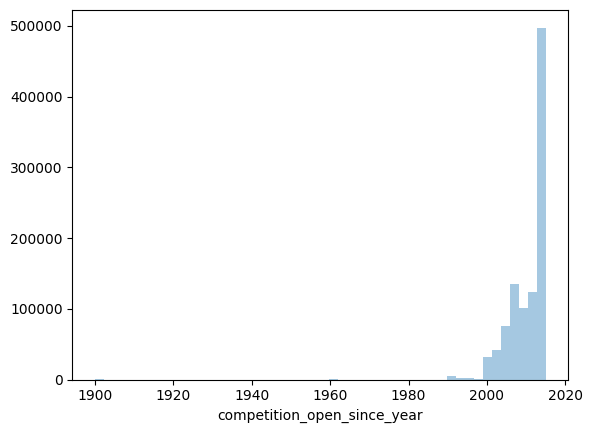

In [16]:
sns.distplot( df1['competition_open_since_year'], kde=False )
fig.set(xlabel ="competition_open_since_year", ylabel = "count");

### 1.6.2 Categorical Atributes

In [17]:
# verify the unique categories of each categorical variable
for col in cat_attributes:
    print(col, cat_attributes[col].unique())

state_holiday ['0' 'a' 'b' 'c']
store_type ['c' 'a' 'd' 'b']
assortment ['a' 'c' 'b']


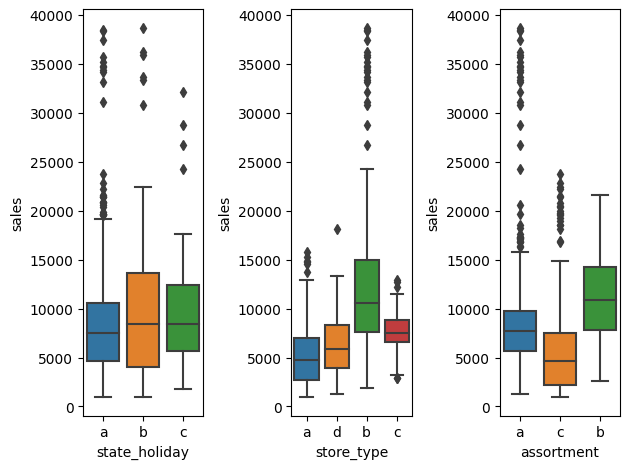

In [18]:
# select only dataframe part with holidays and sales > 0
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

plt.tight_layout()

# 2.0 FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

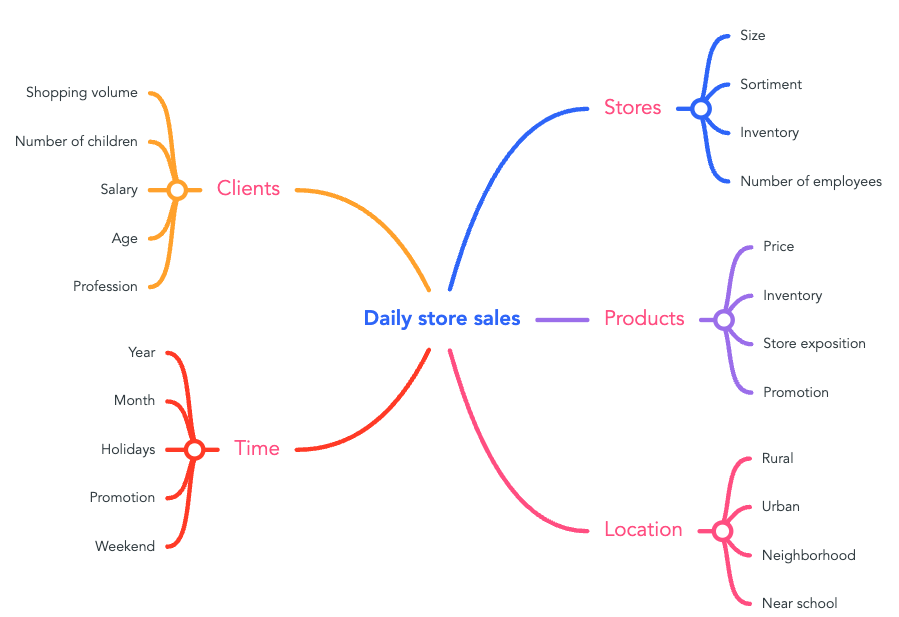

In [20]:
Image("./img/hypothesis.png", width=500, height=500)


## 2.2 Hypothesis

1. Stores with more assortments sell more.
2. Stores with closer competitors sell less.
3. Stores with closer competitors should sell less.
4. Stores with more promotion days sell more.
5. Stores open over the Christmas holiday sell more.
6. Stores sell more over the years.
7. Stores sell more in the second semester.
8. Stores sell more after the 10th of every month.
9. Stores sell less on weekends.
10. Stores sell less during school holidays.

## 2.3 Feature Engineering

In [21]:
# variables necessary to test the business hypothesis

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# year week >> to see temporal evolution per week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# -----------
# competition since -> months since competition is open:
                         
# a. pegando month e year como string para concatenar no jeito mais simples
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(str)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(str)
df2['competition_open_since'] =df2['competition_open_since_month'] + '-' + df2['competition_open_since_year'] 
# b. como o resultado no passo anterior é objeto, preciso passar p/ date
df2['competition_open_since'] = pd.to_datetime( df2['competition_open_since'])

# c. Getting the diff between to dates in form of months
df2['competition_since'] = ((df2.date - df2.competition_open_since)/np.timedelta64(1, 'M'))


# replacing a,b... with names of categories
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 DATA FILTERING


In [22]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas


In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [24]:
cols_drop = ['customers', 'open']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 EXPLORATORY ANALYSIS

In [25]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Response Variable

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:15<00:00,  3.88s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,7.203334e-10,2929.775561,-2.929647e+07,inf,0.012396,3.978553e-113
gamma,2.640120e-09,3358.626954,-2.819979e+07,inf,0.029948,0.000000e+00
beta,3.301089e-09,3294.081903,-2.801113e+07,inf,0.031932,0.000000e+00
norm,2.425549e-08,5274.885757,-2.632722e+07,inf,0.088010,0.000000e+00


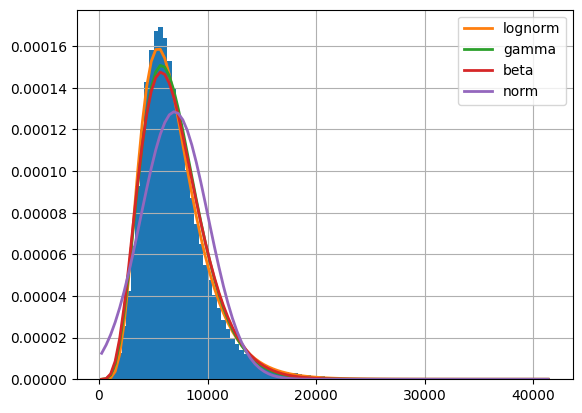

In [26]:
sns.distplot( df4['sales'], kde=False  )

from fitter import Fitter, get_common_distributions, get_distributions

f = Fitter(df4['sales'],
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "norm"])
f.fit()
f.summary()

### 4.1.2 Numerical Variable

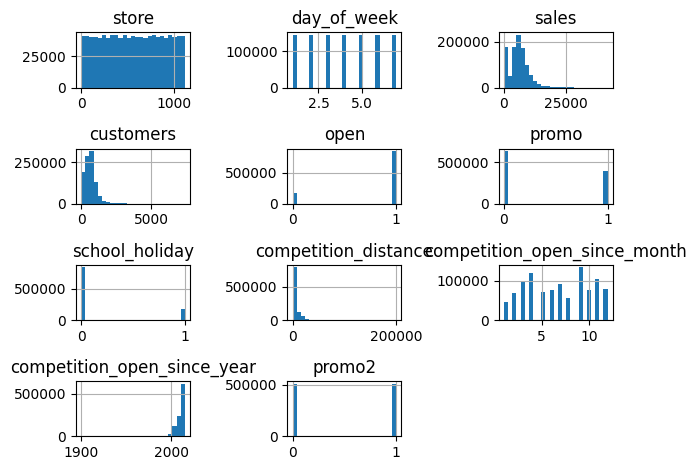

In [27]:
num_attributes.hist( bins=25 );
plt.tight_layout()

### 4.1.3 Categorical Variable

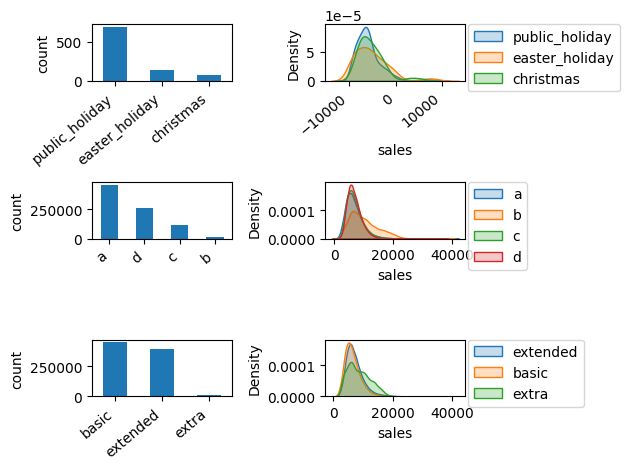

In [28]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
fig = a['state_holiday'].value_counts().plot(kind='bar')
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right");
fig.set(ylabel = "count");
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")

plt.subplot( 3, 2, 2 )
fig = sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
fig = sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
fig = sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# store_type
plt.subplot( 3, 2, 3 )
fig = df4['store_type'].value_counts().plot(kind='bar')
fig.set(ylabel = "count");
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")


plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# assortment
plt.subplot( 3, 2, 5 )
fig = df4['assortment'].value_counts().plot(kind='bar')
fig.set(ylabel = "count");
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")


plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
 
    

## 4.2 Bivariate analysis

###### H1: Stores with extended assortments sell more

<AxesSubplot: xlabel='year_week'>

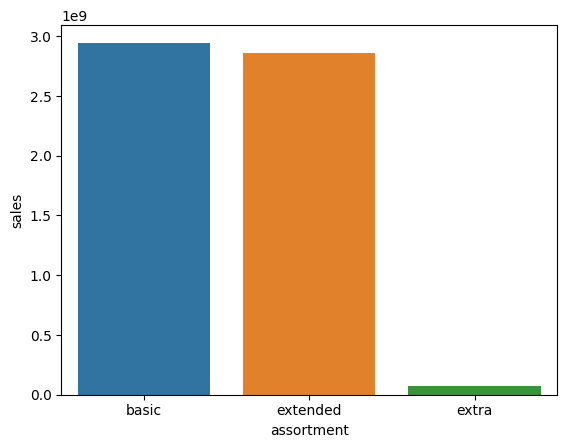

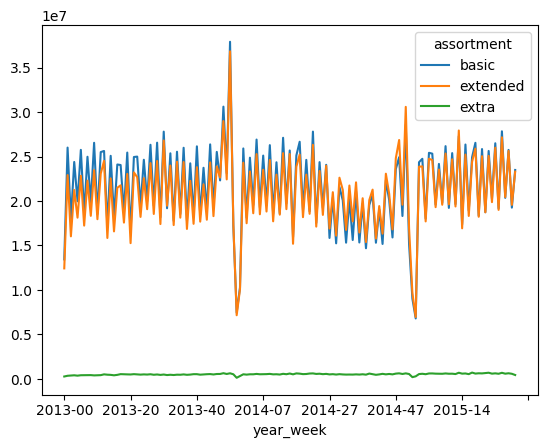

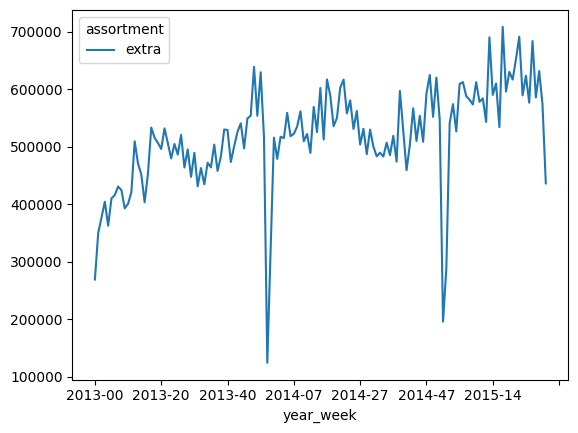

In [29]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(aux1,x='assortment',y='sales')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

###### H2: Stores with closer competitors sell less

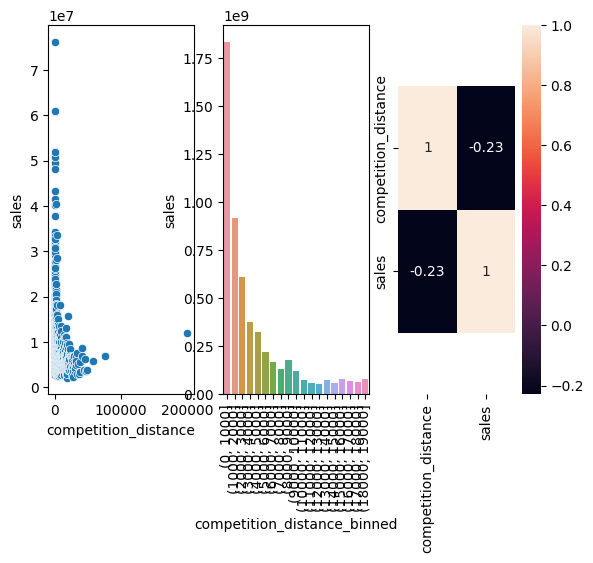

In [30]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

###### H3: Stores with more promotions sell more

In [31]:
aux1 = df4[df4['promo'] == 1] # promo 1 -> yes
aux2 = aux1[['sales','promo']].mean()

aux3 = df4[df4['promo'] == 0] # promo 0 -> no promotion
aux4 = aux3[['sales','promo']].mean()

print('Mean sales during promo days: R$ {} '.format( aux2[0]) )
print('Mean sales during days without promo: R$ {} '.format( aux4[0]) )

# fig = sns.regplot( x='competition_since', y='sales', data=aux1);
###### H3: Stores with competitors for a longer time sell more.

Mean sales during promo days: R$ 8228.739730679934 
Mean sales during days without promo: R$ 5929.826183034807 


###### H4: Stores open over the Christmas holiday sell more

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


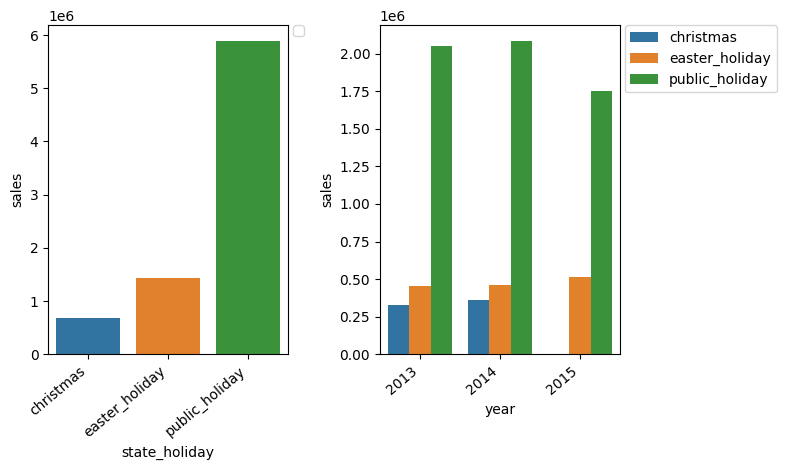

In [32]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
fig = sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
fig = sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
plt.tight_layout()
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<AxesSubplot: xlabel='year_week'>

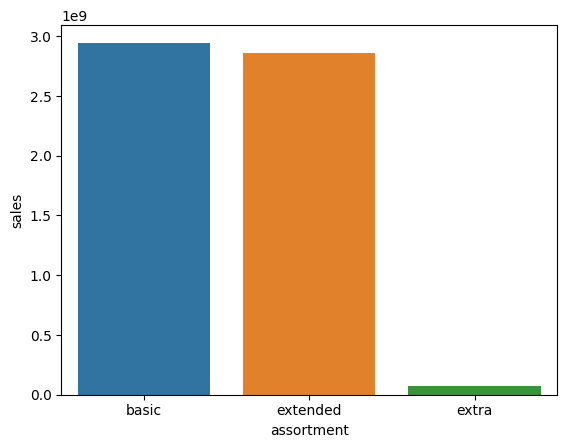

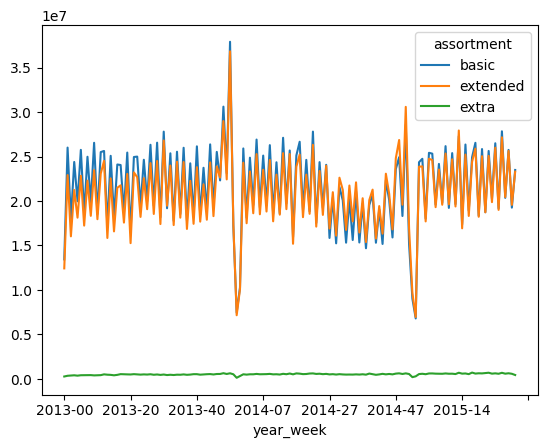

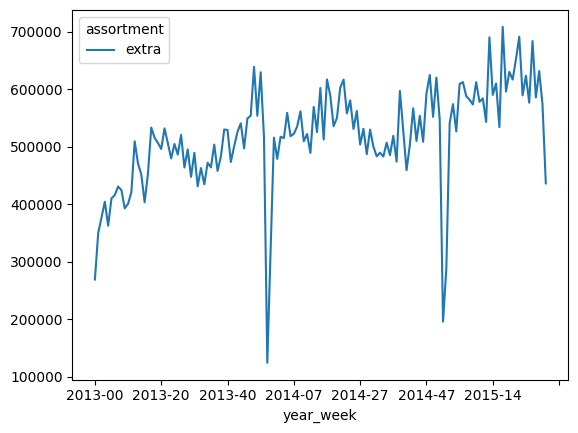

In [33]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

###### H5: Stores sell more over the years

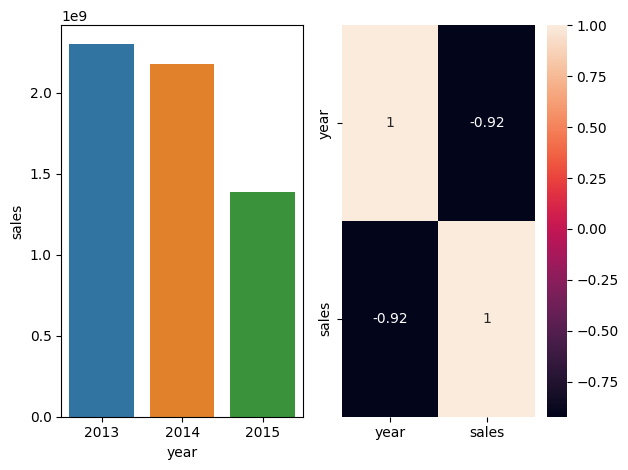

In [34]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='year', y='sales', data=aux );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );
plt.tight_layout()


###### H6: Stores sell more in the second semester

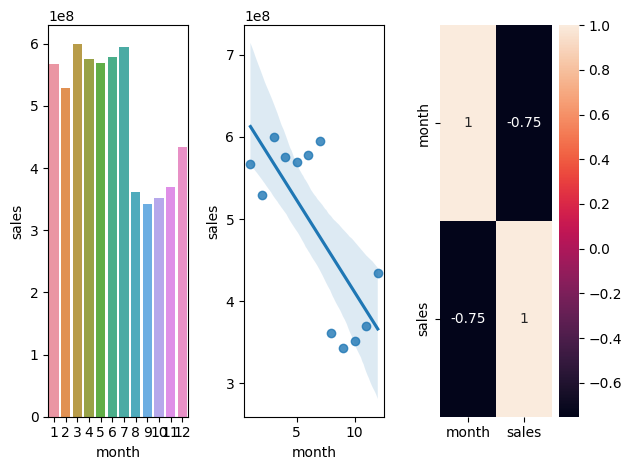

In [35]:
aux = df4[['sales','month']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data = aux,x = 'month',y = 'sales')

plt.subplot(1,3,2)
sns.regplot(data = aux, x = 'month',y = 'sales')

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method = 'pearson'), annot = True)

plt.tight_layout()

###### H7: Stores sell more after the 10th of every month


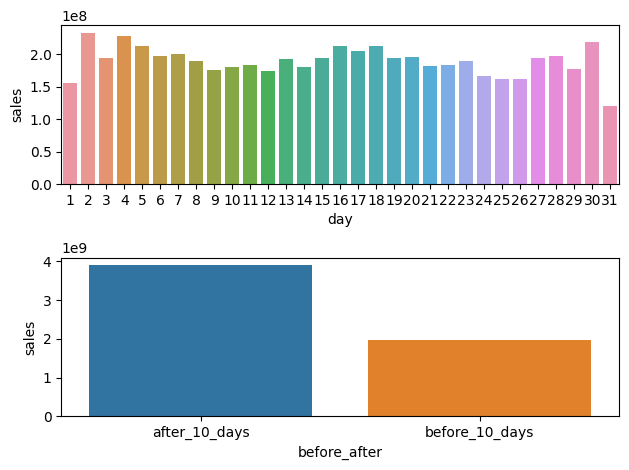

In [36]:
aux1 = df4[['sales','day']].groupby('day').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(data = aux1, x = 'day', y = 'sales')

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.tight_layout()

###### H8: Stores sell less on weekends

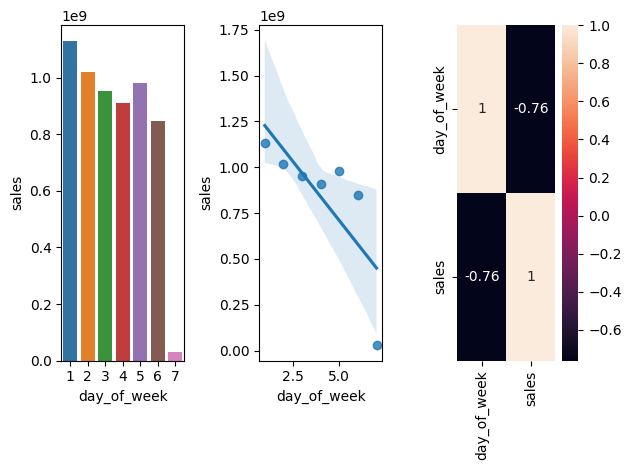

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.tight_layout()

###### H9: Stores sell less during school holidays

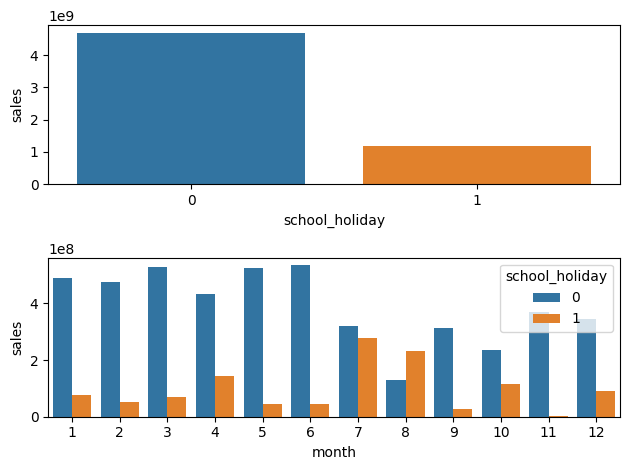

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

plt.tight_layout()

## 4.3 Multivariate analysis

In [39]:
# using the filtered dataset
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 4.3.1 Numerical attributes

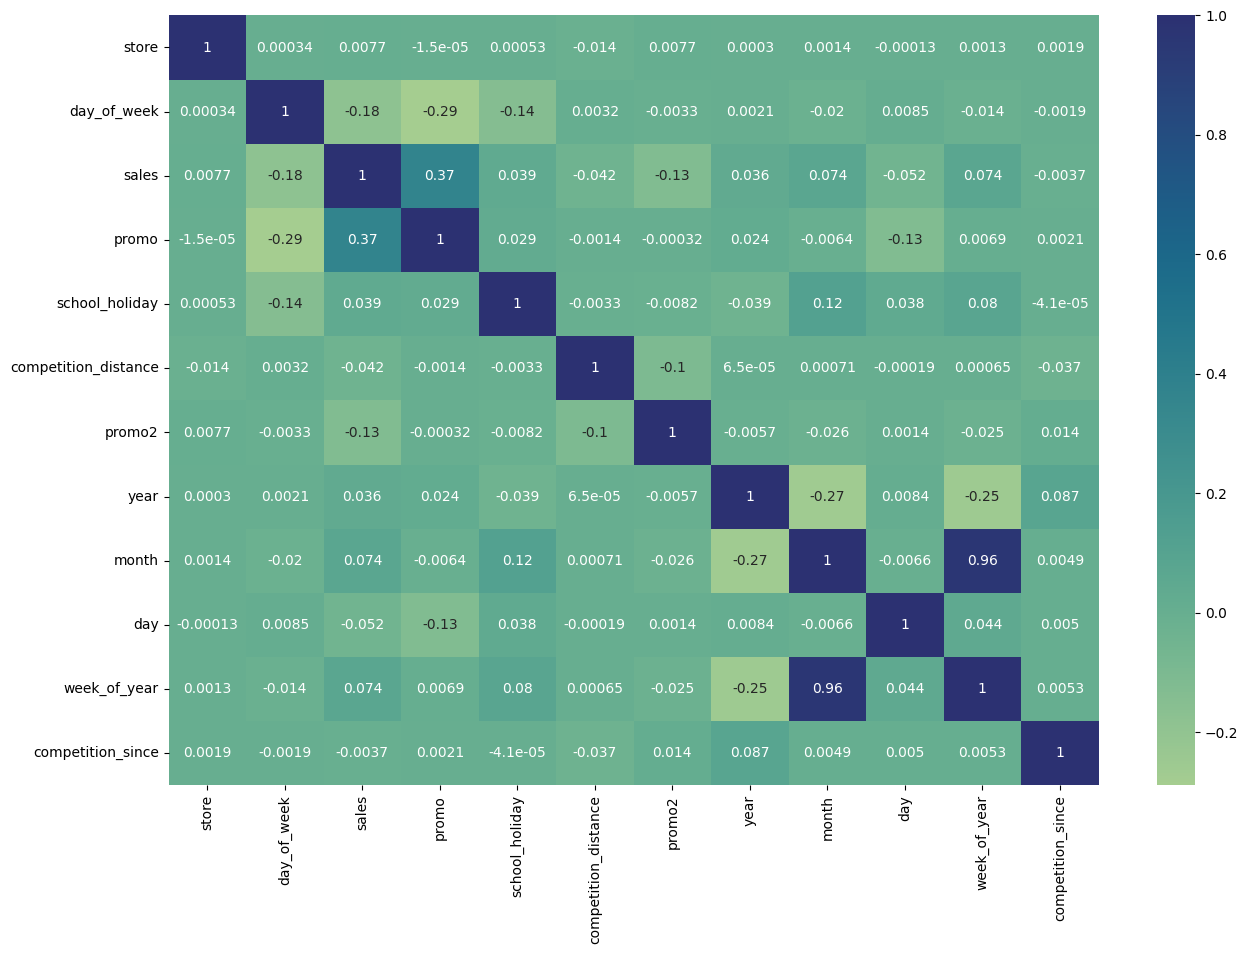

In [40]:
plt.figure(figsize=(15,10))
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True, fmt='.2g', cmap="crest");

### 4.3.2 Categorical attributes 

<AxesSubplot: >

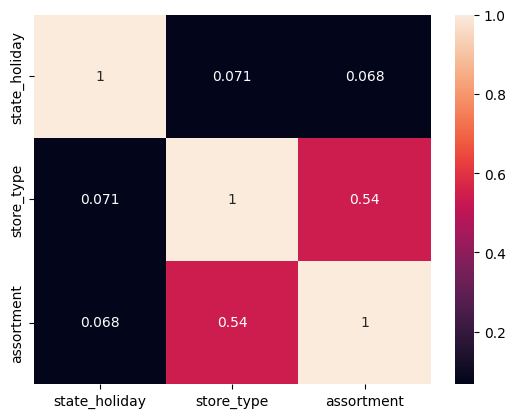

In [41]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data preparation

In [42]:
df5 = df4.copy()

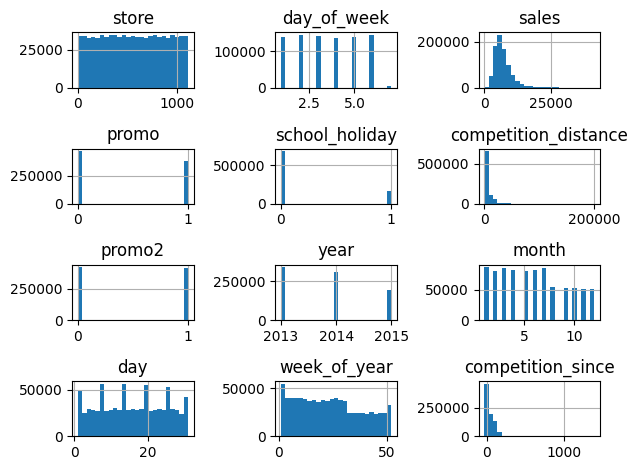

In [43]:
# checking data distribution 
num_attributes.hist( bins=25 );
plt.tight_layout()

## 5.1. Normalization

In [44]:
# not applied, as none of the variables has a gaussian distribution (see item 4.1.2)

## 5.2 Rescaling

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition since
df5['competition_since'] = rs.fit_transform( df5[['competition_since']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3 Transformation

### 5.3.1 Encoding

In [46]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response variable transformation

In [47]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [48]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 Feature selection

In [49]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test 

In [50]:
''' dropping variables that were altered in the step 5.3.3 and 
# variables with time format: competition_open_since_month, competition_open_since_year, year_week
competition_open_since '''

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week' , 
            'competition_open_since_month','competition_open_since_year', 'year_week' ,'competition_open_since']
df6 = df6.drop( cols_drop, axis=1 )

In [51]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as feature selector

In [52]:
# # codigo comentado p/ evitar demora!


# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best features from Boruta

In [53]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


cols_selected_boruta = 
['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'competition_since',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

## 6.3 Feature selection: Boruta and experience

In [54]:
cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'promo2', 'competition_since', 'day_of_week_sin',  'day_of_week_cos', 'month_cos', 'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos','week_of_year_sin']

In [55]:
# reassemble the train dataset (reinclude sales and date) -> to be used in the cross-validation
# columns to add
feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

# 7.0 Machile learning modeling

In [56]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

# Time series data preparation for cross-validation
x_training = X_train[ cols_selected_full ]

## 7.1 Average model

In [57]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear regression 

In [58]:
# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1881.353491,0.282492,2737.597166


### 7.2.1 Linear tegression - Cross validation

In [59]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2113.39 +/- 350.9,0.29 +/- 0.01,3031.72 +/- 535.29


## 7.3 Linear regression regularized (Lasso)

In [60]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1900.675072,0.288503,2768.590177


### 7.3.1  Lasso - Cross validation

In [61]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2128.81 +/- 368.49,0.3 +/- 0.01,3066.31 +/- 550.14


## 7.4 Random forest regressor

In [62]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,736.299902,0.106176,1133.657364


### 7.4.1 Random forest regressor - Cross validation

In [63]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,884.94 +/- 244.5,0.12 +/- 0.02,1324.47 +/- 364.81


## 7.6 Comparing model performance

### 7.6.1 Single performance

In [64]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,736.299902,0.106176,1133.657364
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1881.353491,0.282492,2737.597166
0,Linear Regression - Lasso,1900.675072,0.288503,2768.590177


### 7.6.2 Real performance: cross-validation

In [65]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2113.39 +/- 350.9,0.29 +/- 0.01,3031.72 +/- 535.29
0,Lasso,2128.81 +/- 368.49,0.3 +/- 0.01,3066.31 +/- 550.14
0,Random Forest Regressor,884.94 +/- 244.5,0.12 +/- 0.02,1324.47 +/- 364.81


# 8.0 Translating and interpreting the error

In [66]:
df9 = X_test[ cols_selected_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_rf )

## 8.1 Business performance

In [67]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [68]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
922,923,399688.652290,394100.207643,405277.096938,5588.444647,1.153144
549,550,310669.399371,307471.658847,313867.139894,3197.740524,0.668210
291,292,110077.645232,106486.157906,113669.132559,3591.487327,0.627132
908,909,232321.470021,224647.263462,239995.676580,7674.206559,0.517656
273,274,168681.003557,166711.445500,170650.561613,1969.558057,0.337358


<AxesSubplot: xlabel='store', ylabel='MAPE'>

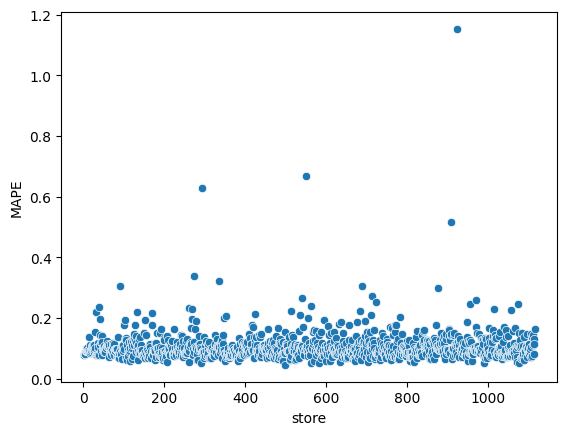

In [69]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 8.2 Total performance

In [70]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,486,970.52"
1,worst_scenario,"R$282,663,190.49"
2,best_scenario,"R$284,310,750.55"


## 8.3 Machine learning performance

In [71]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

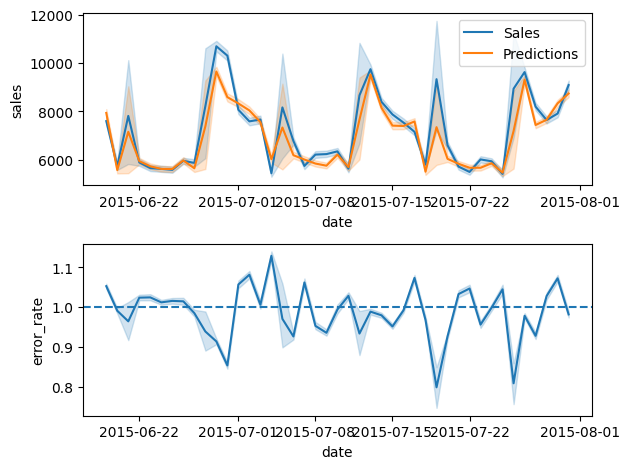

In [79]:
plt.subplot( 2, 1, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='Sales' )
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions' )

plt.subplot( 2, 1, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.tight_layout()